# Reconstruction and analysis of B-cell lineage trees from single cell data using Immcantation


![](assets/dowser-tutorial-cover.png)



Human B cells play a fundamental role in the adaptive immune response to infection and vaccination, as well as the pathology of allergies and many autoimmune diseases. Central to all of these processes is the fact that B cells are an evolutionary system, and undergo rapid somatic hypermutation and antigen-driven selection as part of the adaptive immune response. The similarities between this B cell response and evolution by natural selection have made phylogenetic methods a powerful means of characterizing important processes, such as immunological memory formation. Recent methodological work has led to the development of phylogenetic methods that adjust for the unique features of B cell evolution. Further, advances in single cell sequencing can now provide an unprecedented resolution of information, including linked heavy and light chain data, as well as the associated transcriptional states of individual B cells. In this tutorial, we show how single cell information can be integrated into B cell phylogenetic analysis using the Immcantation suite (Immcantation.org).

**This tutorial covers:**

Beginning with processed single cell RNA-seq (scRNA-seq) + BCR data from 10X Genomics, we will show:

- how cell type annotations can be associated with BCR sequences,
- how clonal clusters can be identified, and 
- how B cell phylogenetic trees can be built and visualized using these data sources.

## Resources

- You can email [immcantation@googlegroups.com](mailto:immcantation@googlegroups.com) with any questions or issues.
- Documentation: http://immcantation.org
- Source code and bug reports: https://bitbucket.org/kleinstein/immcantation
- Docker/Singularity container for this lab: https://hub.docker.com/r/immcantation/lab

## How to use the notebook

Jupyter Notebook documentation: https://jupyter-notebook.readthedocs.io/en/stable/

**Ctrl+Enter** will run the code in the selected cell and **Shift+Enter** will run the code and move to the following cell.

## Inside this container

This container comes with software and example data that is ready to use. The commands `versions report` and `builds report` show the versions and dates respectively of the tools and data.

### Software versions
Use this command to list the software versions

In [95]:
%%bash
versions report

immcantation: devel
date: 2021.10.28

presto: 0.7.0
changeo: 1.2.0
alakazam: 1.1.0.999
shazam: 1.1.0.999
tigger: 1.0.0.999
scoper: 1.1.0.999
dowser: 0.1.0
enchantr: 0.0.0
prestor: 0.0.7
rabhit: 0.1.5
rdi: 1.0.0
igphyml: 1.1.3

airr-py: 1.3.1
airr-r: 1.3.0
blast: 2.9.0
cd-hit: 4.8.1
igblast: 1.17.1
muscle: 3.8.425
phylip: 3.697
vsearch: 2.13.6


### Build versions
Use this command to list the date and changesets used during the image build.

In [96]:
%%bash
builds report

date: 2021-10-29 13:04:53 UTC
immcantation: 4.2.0-41-ga82b5a731fac+
presto: 0.7.0-1-gb503b521e246
changeo: 1.1.0-21-gfbc58363baf1
alakazam: 1.1.0-30-g2046c3bbf568
shazam: 1.1.0-9-g8c240bedd5ba
tigger: 6c31d6a59167+
rdi: d27b9067cab6+
scoper: 1.1.0-31-g1caf95e23c8d+
prestor: 0.0.7


### Example data used in the tutorial

- `../data/BCR.data.tsv`: B-Cell Receptor Data. Adaptive Immune Receptor Repertoire (AIRR) tsv BCRs already aligned to IMGT V, D, and J genes. To learn more visit  https://immcantation.readthedocs.io/en/stable/tutorials/tutorials.html


- `../data/GEX.data.rds`: Gene Expression Data. This file contains a Seurat object with RNA-seq data already processed and annotated. For examples visit https://satijalab.org/seurat/articles/pbmc3k_tutorial.html


## Outline of tutorial

1. B cell phylogenetics background.

1. Combining gene expression and BCR sequences.

1. Identifying clonal clusters, reconstruct germlines.

1. Building and visualizing trees.

1. Tree analysis, detecting ongoing evolution.




## B cells underlie both immune function and pathology

![](assets/dowser-tutorial/bcells.png)

## BCRs are first produced by random recombination


## Each B cell has a single type of receptor


## B cell affinity maturation



## Adaptive Immune Receptor Repertoire (AIRR) sequencing



## B cell phylogenetic inference


## Trees link sources of B cell diversity


## Read in data to R session


In [97]:
# R for Python
# Enable use of R magic to run R code
import rpy2.rinterface
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [98]:
%%R
suppressPackageStartupMessages(library(alakazam))
suppressPackageStartupMessages(library(Seurat))

# Read BCR data
bcr_db <- readChangeoDb("../data/BCR.data.tsv")

# Read GEX data
gex_db <- readRDS("../data/GEX.data.rds")


## What’s in the box?



In [99]:
%%R
library(Seurat)
# Object summary
print(gex_db)

An object of class Seurat 
18989 features across 3865 samples within 1 assay 
Active assay: RNA (18989 features, 1726 variable features)
 2 dimensional reductions calculated: pca, umap


In [100]:
%%R
# Cell type annotations
head(Idents(gex_db),1)

P05_FNA_12_Y1_TCACAAGTCAAACAAG 
                         CD4 T 
Levels: CD4 T Naive B CD8 T DC/Monocyte GC B NK RMB PB


In [101]:
%%R
suppressPackageStartupMessages(library(dplyr))
# Object summary
head(bcr_db,1)

# A tibble: 1 × 71
  sequence_id sequence rev_comp productive v_call d_call j_call sequence_alignm…
  <chr>       <chr>    <lgl>    <lgl>      <chr>  <chr>  <chr>  <chr>           
1 CCACTACCAG… ATACTCT… NA       TRUE       IGHV4… IGHD3… IGHJ3… CAGGTGCAGCTGCAG…
# … with 63 more variables: germline_alignment <lgl>, junction <chr>,
#   junction_aa <lgl>, v_cigar <lgl>, d_cigar <lgl>, j_cigar <lgl>,
#   vj_in_frame <lgl>, stop_codon <lgl>, v_sequence_start <dbl>,
#   v_sequence_end <dbl>, v_germline_start <dbl>, v_germline_end <dbl>,
#   np1_length <dbl>, d_sequence_start <dbl>, d_sequence_end <dbl>,
#   d_germline_start <dbl>, d_germline_end <dbl>, np2_length <dbl>,
#   j_sequence_start <dbl>, j_sequence_end <dbl>, j_germline_start <dbl>, …


In [102]:
%%R
# check out select columns
head(select(bcr_db, cell_id, v_call, j_call, sample, day),1)

# A tibble: 1 × 5
  cell_id            v_call      j_call   sample            day
  <chr>              <chr>       <chr>    <chr>           <dbl>
1 CCACTACCAGTATCTG-1 IGHV4-59*01 IGHJ3*02 P05_FNA_3_12_Y1    12


## Add BCR data to Seurat object


In [103]:
%%R
# Make cell IDs in BCR match those in Seurat Object
bcr_db$cell_id_unique = paste0(bcr_db$sample, "_", bcr_db$cell_id)
bcr_db$cell_id_unique = gsub("-1","", bcr_db$cell_id_unique)
bcr_db$cell_id_unique[1]

[1] "P05_FNA_3_12_Y1_CCACTACCAGTATCTG"


In [104]:
%%R
Cells(gex_db)[1]

[1] "P05_FNA_12_Y1_TCACAAGTCAAACAAG"


In [105]:
%%R
# match index from BCR to GEX information
match.index = match(Cells(gex_db), bcr_db$cell_id_unique)
# What proportion of cells don’t have BCRs?
mean(is.na(match.index))

[1] 0.2455369


In [106]:
%%R
# Just to double check..
mean(Cells(gex_db) == bcr_db$cell_id_unique[match.index],na.rm=TRUE)


[1] 1


### Do cells annotated as B cells actually have BCRs? Do non-B cells express BCRs?

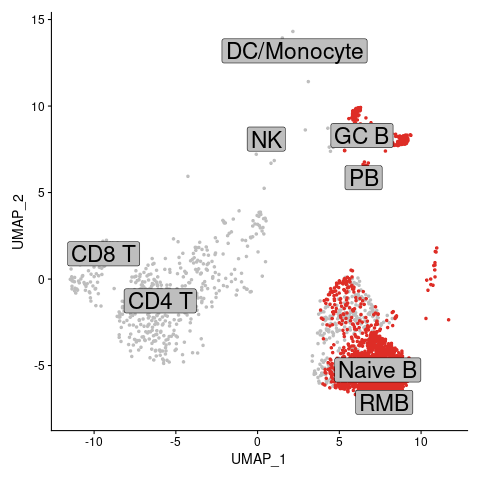

In [107]:
%%R
# label whether BCR found in cell
gex_db$contains_bcr = !is.na(match.index)
# List of cells with BCRs
highlighted.cells = Cells(gex_db)[which(gex_db$contains_bcr)]
# Plot UMAP with BCR-containing cells
DimPlot(object = gex_db, reduction = "umap",
   cells.highlight = highlighted.cells, label =
   TRUE, cols="gray", pt.size = 1.0, label.size=8,
   label.box=TRUE) + NoLegend()



## Add GEX data to BCR object


In [108]:
%%R
# Match indexes from GEX to BCR data
# Different from BCR to GEX!
match.index = match(bcr_db$cell_id_unique, Cells(gex_db))
# What proportion of BCRs don’t have GEX information?
mean(is.na(match.index))

[1] 0.09243697


In [109]:
%%R
# Add annotations to BCR data
cell.annotation = as.character(Idents(gex_db))
bcr_db$gex_annotation= unlist(lapply(match.index,
function(x){ifelse(is.na(x),NA, cell.annotation[x])}))

In [110]:
%%R
# Add UMAP coordinates to BCR data
umap1 = gex_db@reductions$umap@cell.embeddings[,1]
umap2 = gex_db@reductions$umap@cell.embeddings[,2]
bcr_db$gex_umap1= unlist(lapply(match.index,
function(x){ifelse(is.na(x),NA, umap1[x])}))
bcr_db$gex_umap2= unlist(lapply(match.index,
function(x){ifelse(is.na(x),NA, umap2[x])}))

In [111]:
%%R
# Remove cells that didn’t match
bcr_db = filter(bcr_db, !is.na(gex_annotation))

### Ensure information transferred from Seurat object

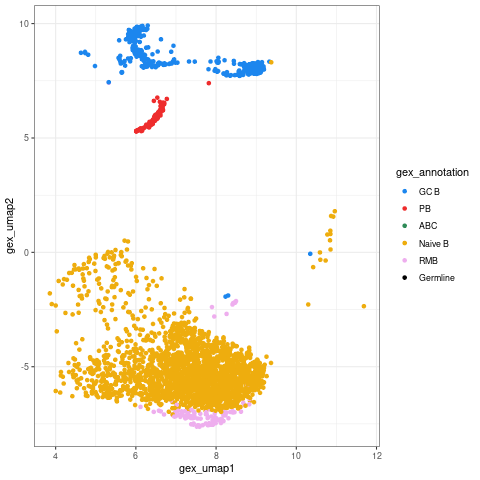

In [112]:
%%R
suppressPackageStartupMessages(library(ggplot2))
# Set up color palette for annotations
col_anno = c(
"GC B"="dodgerblue2",
"PB"="firebrick2",
"ABC"="seagreen",
"Naive B"="darkgoldenrod2",
"RMB"="plum2",
"Germline"="black")
# Plot UMAP from bcr_db
ggplot(bcr_db) +
geom_point(aes(x = gex_umap1, y = gex_umap2,
color = gex_annotation)) +
scale_colour_manual(values=col_anno) +
theme_bw()


## Add GEX data to BCR object



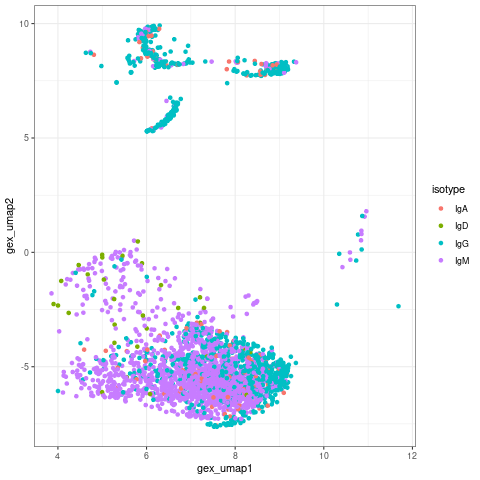

In [113]:
%%R
# Plot isotype on UMAP
ggplot(bcr_db) +
geom_point(aes(x=gex_umap1,
y = gex_umap2,
color = isotype)) +
theme_bw()

## Identifying clonal clusters




## Picking a threshold using shazam




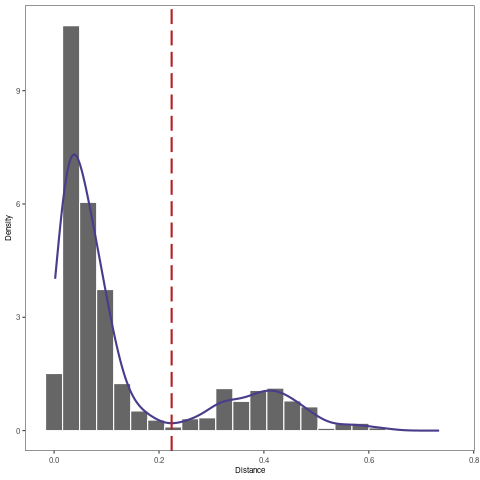

In [114]:
%%R
suppressPackageStartupMessages(library(shazam))
# Find threshold using heavy chains
dist_ham <- distToNearest(filter(bcr_db,
locus=="IGH"))
output <- findThreshold(dist_ham$dist_nearest)
threshold <- output@threshold
# Plot distance to each nearest neighbor
plotDensityThreshold(output)


## Performing clustering using scoper




R[write to console]: Running defineClonesScoper in bulk mode



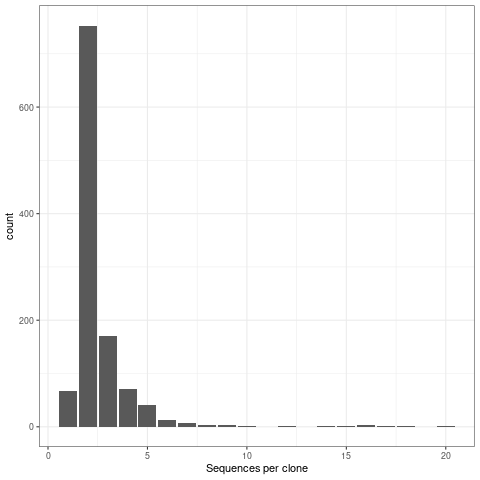

In [115]:
%%R
suppressPackageStartupMessages(library(scoper))
# Assign clonal clusters
results <- hierarchicalClones(dist_ham,
threshold=threshold)
results_db <- as.data.frame(results)
# get clone sizes using dplyr functions
clone_sizes <- countClones(results_db)
# Plot cells per clone
ggplot(clone_sizes, aes(x=seq_count))+
geom_bar() + theme_bw() +
xlab("Sequences per clone")



## Reconstruct germlines using dowser

Note: If you opted for the native installation, you can obtain reference germlines from IMGT with:

```
git clone https://bitbucket.org/kleinstein/immcantation
immcantation/scripts/fetch_imgtdb.sh
```
 



In [116]:
%%R
suppressPackageStartupMessages(library(dowser))

# read in IMGT data if downloaded on your own (above)
# and update `dir` to use the path to your `human/vdj` folder
# references = readIMGT(dir = "human/vdj/")

# read in IMGT data if using in Docker image
references = readIMGT(dir = "/usr/local/share/germlines/imgt/human/vdj")
# Reconstruct germlines
results_db = createGermlines(results_db, references)
# Check output column
results_db$germline_alignment_d_mask[1]


[1] "Read in 1115 from 17 fasta files"
<simpleError in rep("V", nchar(v_seq)): invalid 'times' argument>
<simpleError in rep("V", nchar(v_seq)): invalid 'times' argument>
[1] "CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGAAGCCTTCGGAGACCCTGTCCCTCACCTGCGCTGTCTCTGGTTACTCCATCAGC.........AGTGGTTACTACTGGGGCTGGATCCGGCAGCCCCCAGGGAAGGGGCTGGAGTGGATTGGGAGTATCTATCATAGT.........GGGAGCACCTACTACAACCCGTCCCTCAAG...AGTCGAGTCACCATATCAGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAGCTCTGTGACCGCCGCAGACACGGCCGTGTATTACTGTGCGAGANNNNNNNNNNNNNNNNNNNNNNNNTTTGACTACTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG"


## Formatting clones with dowser



In [117]:
%%R
# Make clone objects with aligned, processed sequences
# collapse identical sequences unless differ by trait
# add up duplicate_count column for collapsed sequences
# store day, isotype, gex_annotation
# discard clones with < 5 distinct sequences
clones = formatClones(results_db,
   traits = c("day", "isotype", "gex_annotation"),
   num_fields=c("duplicate_count"), minseq=5)
clones


|======================================================|100% ~0 s remaining                    # A tibble: 66 × 4
   clone_id data       locus  seqs
   <chr>    <list>     <chr> <int>
 1 403      <airrClon> IGH      16
 2 457      <airrClon> IGH      15
 3 512      <airrClon> IGH      15
 4 823      <airrClon> IGH      15
 5 12       <airrClon> IGH      13
 6 539      <airrClon> IGH      13
 7 446      <airrClon> IGH      12
 8 1006     <airrClon> IGH       9
 9 1125     <airrClon> IGH       9
10 442      <airrClon> IGH       9
# … with 56 more rows


## Constructing trees



## Tree building with dowser




In [118]:
%%R
# Two options for maximum parsimony trees
trees = getTrees(clones)
trees = getTrees(clones, build="dnapars",
exec="/usr/local/bin/dnapars")
# Two options for standard maximum likelihood trees
trees = getTrees(clones, build="pml", sub_model="GTR")
trees = getTrees(clones, build="dnaml",
exec="/usr/local/bin/dnaml")
# B cell specific maximum likelihood with IgPhyML
trees = getTrees(clones, build="igphyml",
exec="/usr/local/share/igphyml/src/igphyml", nproc=2)
trees


[1] "sub_model GTR"
optimize edge weights:  -1558.412 --> -1549.357 
optimize base frequencies:  -1549.357 --> -1545.877 
optimize rate matrix:  -1545.877 --> -1532.272 
optimize edge weights:  -1532.272 --> -1532.212 
optimize topology:  -1532.212 --> -1532.212 
0 
optimize base frequencies:  -1532.212 --> -1531.64 
optimize rate matrix:  -1531.64 --> -1531.575 
optimize edge weights:  -1531.575 --> -1531.568 
optimize base frequencies:  -1531.568 --> -1531.56 
optimize rate matrix:  -1531.56 --> -1531.559 
optimize edge weights:  -1531.559 --> -1531.559 
optimize base frequencies:  -1531.559 --> -1531.558 
optimize rate matrix:  -1531.558 --> -1531.558 
optimize edge weights:  -1531.558 --> -1531.558 
optimize base frequencies:  -1531.558 --> -1531.558 
optimize rate matrix:  -1531.558 --> -1531.558 
optimize edge weights:  -1531.558 --> -1531.558 
[1] "sub_model GTR"
optimize edge weights:  -1157.811 --> -1155.287 
optimize base frequencies:  -1155.287 --> -1152.879 
optimize rate m

optimize edge weights:  -1094.582 --> -1094.562 
optimize topology:  -1094.562 --> -1093.304 
optimize topology:  -1093.304 --> -1093.304 
1 
optimize base frequencies:  -1093.304 --> -1093.129 
optimize rate matrix:  -1093.129 --> -1092.931 
optimize edge weights:  -1092.931 --> -1092.928 
optimize topology:  -1092.928 --> -1092.928 
0 
optimize base frequencies:  -1092.928 --> -1092.912 
optimize rate matrix:  -1092.912 --> -1092.911 
optimize edge weights:  -1092.911 --> -1092.91 
optimize base frequencies:  -1092.91 --> -1092.91 
optimize rate matrix:  -1092.91 --> -1092.91 
optimize edge weights:  -1092.91 --> -1092.91 
optimize base frequencies:  -1092.91 --> -1092.91 
optimize rate matrix:  -1092.91 --> -1092.91 
optimize edge weights:  -1092.91 --> -1092.91 
[1] "sub_model GTR"
optimize edge weights:  -1172.259 --> -1168.87 
optimize base frequencies:  -1168.87 --> -1164.813 
optimize rate matrix:  -1164.813 --> -1144.233 
optimize edge weights:  -1144.233 --> -1144.22 
optimiz

optimize edge weights:  -750.7938 --> -749.5818 
optimize base frequencies:  -749.5818 --> -746.8864 
optimize rate matrix:  -746.8864 --> -742.9538 
optimize edge weights:  -742.9538 --> -742.9323 
optimize topology:  -742.9323 --> -742.9323 
optimize topology:  -742.9323 --> -742.9323 
1 
optimize base frequencies:  -742.9323 --> -742.924 
optimize rate matrix:  -742.924 --> -742.9195 
optimize edge weights:  -742.9195 --> -742.9189 
optimize topology:  -742.9189 --> -742.9188 
0 
optimize base frequencies:  -742.9188 --> -742.9186 
optimize rate matrix:  -742.9186 --> -742.9185 
optimize edge weights:  -742.9185 --> -742.9185 
optimize base frequencies:  -742.9185 --> -742.9184 
optimize rate matrix:  -742.9184 --> -742.9184 
optimize edge weights:  -742.9184 --> -742.9184 
optimize base frequencies:  -742.9184 --> -742.9184 
optimize rate matrix:  -742.9184 --> -742.9184 
optimize edge weights:  -742.9184 --> -742.9183 
[1] "sub_model GTR"
optimize edge weights:  -1077.026 --> -107

optimize rate matrix:  -721.0957 --> -721.0957 
optimize edge weights:  -721.0957 --> -721.0957 
optimize base frequencies:  -721.0957 --> -721.0957 
optimize rate matrix:  -721.0957 --> -721.0957 
optimize edge weights:  -721.0957 --> -721.0957 
[1] "sub_model GTR"
optimize edge weights:  -848.7337 --> -843.0931 
optimize base frequencies:  -843.0931 --> -837.834 
optimize rate matrix:  -837.834 --> -822.9134 
optimize edge weights:  -822.9134 --> -822.8732 
optimize topology:  -822.8732 --> -822.8732 
0 
optimize base frequencies:  -822.8732 --> -822.6507 
optimize rate matrix:  -822.6507 --> -822.6313 
optimize edge weights:  -822.6313 --> -822.6295 
optimize base frequencies:  -822.6295 --> -822.6279 
optimize rate matrix:  -822.6279 --> -822.6278 
optimize edge weights:  -822.6278 --> -822.6278 
optimize base frequencies:  -822.6278 --> -822.6277 
optimize rate matrix:  -822.6277 --> -822.6277 
optimize edge weights:  -822.6277 --> -822.6277 
[1] "sub_model GTR"
optimize edge weig

optimize topology:  -794.0407 --> -793.6859 
optimize topology:  -793.6859 --> -793.6859 
2 
optimize base frequencies:  -793.6859 --> -793.615 
optimize rate matrix:  -793.615 --> -793.4969 
optimize edge weights:  -793.4969 --> -793.4883 
optimize topology:  -793.4883 --> -793.4883 
0 
optimize base frequencies:  -793.4883 --> -793.4844 
optimize rate matrix:  -793.4844 --> -793.4825 
optimize edge weights:  -793.4825 --> -793.4823 
optimize base frequencies:  -793.4823 --> -793.4822 
optimize rate matrix:  -793.4822 --> -793.4822 
optimize edge weights:  -793.4822 --> -793.4821 
optimize base frequencies:  -793.4821 --> -793.4821 
optimize rate matrix:  -793.4821 --> -793.4821 
optimize edge weights:  -793.4821 --> -793.4821 
[1] "sub_model GTR"
optimize edge weights:  -764.6919 --> -762.3552 
optimize base frequencies:  -762.3552 --> -758.0296 
optimize rate matrix:  -758.0296 --> -747.8792 
optimize edge weights:  -747.8792 --> -747.8727 
optimize topology:  -747.8727 --> -747.872

optimize edge weights:  -605.7638 --> -605.7638 
[1] "sub_model GTR"
optimize edge weights:  -622.2222 --> -622.013 
optimize base frequencies:  -622.013 --> -617.1457 
optimize rate matrix:  -617.1457 --> -609.3772 
optimize edge weights:  -609.3772 --> -609.3771 
optimize topology:  -609.3771 --> -609.3771 
0 
optimize base frequencies:  -609.3771 --> -609.3619 
optimize rate matrix:  -609.3619 --> -609.3615 
optimize edge weights:  -609.3615 --> -609.3615 
optimize base frequencies:  -609.3615 --> -609.3615 
optimize rate matrix:  -609.3615 --> -609.3615 
optimize edge weights:  -609.3615 --> -609.3615 
[1] "sub_model GTR"
optimize edge weights:  -898.7092 --> -898.5373 
optimize base frequencies:  -898.5373 --> -892.8802 
optimize rate matrix:  -892.8802 --> -877.7483 
optimize edge weights:  -877.7483 --> -877.6948 
optimize topology:  -877.6948 --> -877.6948 
0 
optimize base frequencies:  -877.6948 --> -877.6396 
optimize rate matrix:  -877.6396 --> -877.6362 
optimize edge weig

optimize edge weights:  -741.5418 --> -741.5418 
# A tibble: 66 × 6
   clone_id data       locus  seqs parameters        trees       
   <chr>    <list>     <chr> <int> <named list>      <named list>
 1 403      <airrClon> IGH      16 <named list [13]> <phylo>     
 2 457      <airrClon> IGH      15 <named list [13]> <phylo>     
 3 512      <airrClon> IGH      15 <named list [13]> <phylo>     
 4 823      <airrClon> IGH      15 <named list [13]> <phylo>     
 5 12       <airrClon> IGH      13 <named list [13]> <phylo>     
 6 539      <airrClon> IGH      13 <named list [13]> <phylo>     
 7 446      <airrClon> IGH      12 <named list [13]> <phylo>     
 8 1006     <airrClon> IGH       9 <named list [13]> <phylo>     
 9 1125     <airrClon> IGH       9 <named list [13]> <phylo>     
10 442      <airrClon> IGH       9 <named list [13]> <phylo>     
# … with 56 more rows


## Plotting trees with dowser and ggtree

All tree building methods are plotted using the same method in dowser.



In [119]:
%%R
# Plot all trees
plots = plotTrees(trees, tips="isotype", tipsize=2)

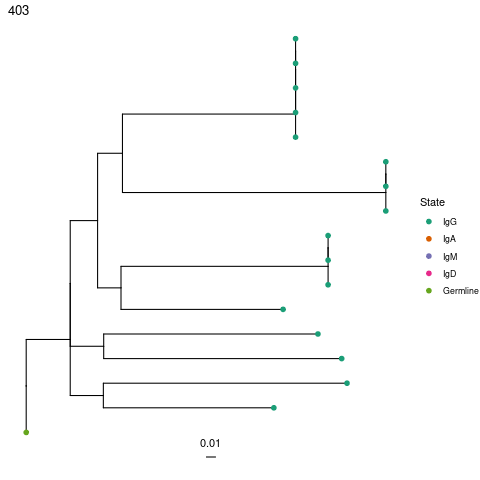

In [120]:
%%R
# Plot the largest tree
plots[[1]]

In [121]:
%%R
# Save PDF of all trees
treesToPDF(plots, file="results/final_data_trees.pdf", nrow=2, ncol=2)

png 
  2 


## More elaborate tree plots




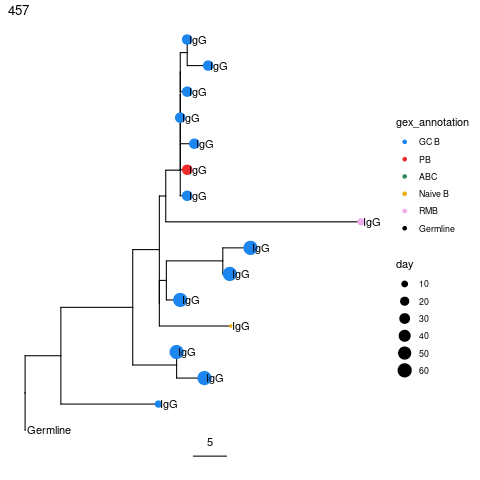

In [122]:
%%R
suppressPackageStartupMessages(library(ggtree))
# Scale branches to mutations rather than mutations/site
trees = scaleBranches(trees)
# Make fancy tree plot of second largest tree
plotTrees(trees, scale=5)[[2]] +
geom_tippoint(aes(colour=gex_annotation, size=day)) +
geom_tiplab(aes(label=isotype), offset=0.002) +
scale_colour_manual(values = col_anno)

## Reconstruct intermediate sequences




In [126]:
%%R
suppressPackageStartupMessages(library(ggtree))
# Collapse nodes with identical sequences
trees = collapseNodes(trees)
# node_nums=TRUE labels each internal node
p = plotTrees(trees, node_nums=TRUE, labelsize=6, scale=5)[[2]] +
   geom_tippoint(aes(colour=gex_annotation, size=day)) + 
   geom_tiplab(aes(label=isotype), offset=0.002) + 
   scale_colour_manual(values = col_anno)
# Get sequence at node 26
getSeq(trees, clone=1018, node=26)

R[write to console]: Error in filter(data, !!rlang::sym("clone_id") == clone)$trees[[1]] : 
  subscript out of bounds




Error in filter(data, !!rlang::sym("clone_id") == clone)$trees[[1]] : 
  subscript out of bounds


RInterpreterError: Failed to parse and evaluate line 'suppressPackageStartupMessages(library(ggtree))\n# Collapse nodes with identical sequences\ntrees = collapseNodes(trees)\n# node_nums=TRUE labels each internal node\np = plotTrees(trees, node_nums=TRUE, labelsize=6, scale=5)[[2]] +\n   geom_tippoint(aes(colour=gex_annotation, size=day)) + \n   geom_tiplab(aes(label=isotype), offset=0.002) + \n   scale_colour_manual(values = col_anno)\n# Get sequence at node 26\ngetSeq(trees, clone=1, node=26)\n'.
R error message: 'Error in filter(data, !!rlang::sym("clone_id") == clone)$trees[[1]] : \n  subscript out of bounds'

## Are lineages measurably evolving?




## Detecting measurable evolution




## Correlation tests with dowser




In [127]:
%%R
# Correlation test
trees = correlationTest(trees, time="day")
# remove trees with one timepoint, order by p value
trees = filter(trees, !is.na(p))
trees = trees[order(trees$p),]
# Fancy tree plots
p = plotTrees(trees)
p = lapply(p, function(x)
   x + 
  geom_tippoint(aes(fill=day),shape=21, size=3)+
  scale_fill_distiller(palette="RdYlBu"))

# Save
treesToPDF(p,file="results/time_data_trees.pdf")

select(trees, clone_id, slope, correlation, p)

# A tibble: 53 × 4
   clone_id  slope correlation      p
   <chr>     <dbl>       <dbl>  <dbl>
 1 988      0.308        0.882 0.0380
 2 512      0.162        0.626 0.0559
 3 553      0.400        0.960 0.0729
 4 138      0.387        0.661 0.117 
 5 759      0.545        0.736 0.172 
 6 720      0.332        0.578 0.182 
 7 380      0.223        0.710 0.200 
 8 411      0.287        0.879 0.203 
 9 446      0.121        0.375 0.224 
10 312      0.0739       0.171 0.300 
# … with 43 more rows


# References

## B cell phylo 

Hoehn, K. B. et al. (2016) The diversity and molecular evolution of B-cell receptors during infection. MBE. https://doi.org/10.1093/molbev/msw015

Hoehn, K. B. et al. (2019) Repertoire-wide phylogenetic models of B cell molecular evolution reveal evolutionary signatures of aging and vaccination. PNAS 201906020.

Hoehn, K. B. et al. (2020) Phylogenetic analysis of migration, differentiation, and class switching in B cells.
bioRxiv. https://doi.org/10.1101/2020.05.30.124446

Hoehn, K. B. et al. (2021) Human B cell lineages engaged by germinal centers following influenza vaccination are measurably evolving. bioRxiv. https://doi.org/10.1101/2021.01.06.425648


## BCR analysis

Gupta,N.T. et al. (2017) Hierarchical clustering can identify b cell clones
with high confidence in ig repertoire sequencing data. The Journal of
Immunology, 1601850.

Gupta,N.T. et al. (2015) Change-o: A toolkit for analyzing large-scale b cell
immunoglobulin repertoire sequencing data. Bioinformatics, 31, 3356–3358.

Nouri,N. and Kleinstein,S.H. (2018a) A spectral clustering-based method
for identifying clones from high-throughput b cell repertoire sequencing data.
Bioinformatics, 34, i341–i349.

Nouri,N. and Kleinstein,S.H. (2018b) Optimized threshold inference for
partitioning of clones from high-throughput b cell repertoire sequencing
data. Frontiers in immunology, 9.

Stern,J.N. et al. (2014) B cells populating the multiple sclerosis brain
mature in the draining cervical lymph nodes. Science translational medicine,
6, 248ra107–248ra107.


Vander Heiden,J.A. et al. (2017) Dysregulation of b cell repertoire
formation in myasthenia gravis patients revealed through deep sequencing.
The Journal of Immunology, 1601415.

Yaari,G. et al. (2012) Quantifying selection in high-throughput
immunoglobulin sequencing data sets. Nucleic acids research, 40,
e134–e134.

Yaari,G. et al. (2013) Models of somatic hypermutation targeting and
substitution based on synonymous mutations from high-throughput
immunoglobulin sequencing data. Frontiers in immunology, 4, 358.
